In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

from accdb_reading import get_measure_df
from measurement_collector import MeasurementCollector
from cache_utils import cache
from tqdm import tqdm
import numpy as np
import pickle

def plot_cm_keras(_model, _X_test, _y_test):
    predictions = _model.predict(_X_test)
    cm = confusion_matrix(_y_test.argmax(axis=1), predictions.argmax(axis=1), normalize="pred")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(_y_test.argmax(axis=1)))
    disp.plot()
    
_db_path = "/home/levcsi/projects/stroke_prediction/data/WUS-v4m.accdb"
_m_path = "/home/levcsi/projects/stroke_prediction/data/biocal.xlsx"
mc = MeasurementCollector('/home/levcsi/projects/stroke_prediction/data', _db_path, _m_path)

2022-04-26 22:11:57.011994: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-26 22:11:57.012104: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.



##### Load measurements for TRAIN #####
### 202110230 (5, 5) ###
measurement is not found in aux data
measurement_path_dict is OK
### 202110251 (2, 3) ###
measurement_path_dict is OK
### 202110280 (0, 1) ###
measurement_path_dict is OK
### 202111021 (2, 3) ###
measurement_path_dict is OK
### 202111041 (0, 0) ###
measurement_path_dict is OK
### 202111141 (5, 5) ###
measurement_path_dict is OK
### 202111181 (0, 0) ###
measurement_path_dict is OK
### 202112020 (5, 5) ###
measurement_path_dict is OK
### 202112131 (2, 4) ###
measurement_path_dict is OK
### 202112171 (2, 4) ###
measurement_path_dict is OK
### 202201061 (0, 0) ###
measurement_path_dict is OK
### 202201191 (4, 4) ###
measurement_path_dict is OK
### 202201310 (5, 5) ###
missing keys: ALL
measurement is not valid (deleted)
### 202203021 (0, 3) ###
missing keys: ALL
measurement is not valid (deleted)
### 202203221 (1, 2) ###
missing keys: ALL
measurement is not valid (deleted)
### 202203230 (1, 1) ###
measurement_path_dict is OK

In [4]:
minutes = 90
length = 25 * 60 * minutes
sample_size = 1000000
limb = "all"

In [3]:
keys_in_order = (("arm", "acc"),
                 ("leg", "acc"),
                 ("arm", "gyr"),
                 ("leg", "gyr"))

X = list()
y = list()
for _ in tqdm(range(sample_size)):
    random_diff_dict, class_value = mc.get_random_mean_with_class_all(mean_type='all', limb=limb,
                                                                      length=length, type_of_set="train")
    instance = list()
    for key in keys_in_order:
        if limb != "all" and key[0] != limb:
            continue
        instance.append(random_diff_dict[key])
    instance = sum(instance, [])
        
    X.append(instance)
    y.append(class_value)

100%|██████████████████████████████| 1000000/1000000 [1:50:27<00:00, 150.88it/s]


In [4]:
del mc

In [5]:
pickle.dump({"X": X, "y": y}, open("./training_data_dict_{}_{}_{}.pkl".format(minutes, sample_size, limb), "wb"))

In [8]:
training_data_dict = pickle.load(open("./training_data_dict_{}_{}_{}.pkl".format(minutes, sample_size, "all"), "rb"))

X = training_data_dict["X"]
y = training_data_dict["y"]

In [9]:
def define_model(inpit_shape):
    ip = Input(shape=(inpit_shape,), name="input")
    x = Dense(units=512, name="hiddel_layer", activation="relu")(ip)
    x = Dense(units=256, name="hiddel_layer_2", activation="relu")(x)
    x = Dense(units=128, name="hiddel_layer_3", activation="relu")(x)
    op = Dense(units=6, name="prediction", activation="softmax")(x)
    _model = Model(inputs=ip, outputs=op, name="full_model")
    _model.summary()
    
    learning_rate = 0.001
    optimizer = Adam(learning_rate, amsgrad=True)
    _model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])
    return _model

In [10]:
y_cat = to_categorical(y)
X_train, X_test, y_train, y_test = train_test_split(np.array(X), np.array(y_cat),
                                                    test_size=0.3, stratify=y,
                                                    random_state=42)

In [11]:
callback = EarlyStopping(monitor='val_loss', patience=20)
model = define_model(X_train.shape[1])
history = model.fit(X_train,
                    y_train,
                    batch_size=100,
                    epochs=1500,
                    callbacks=[callback],
                    verbose=1,
                    validation_data=(X_test, y_test))

Model: "full_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 12)]              0         
                                                                 
 hiddel_layer (Dense)        (None, 512)               6656      
                                                                 
 hiddel_layer_2 (Dense)      (None, 256)               131328    
                                                                 
 hiddel_layer_3 (Dense)      (None, 128)               32896     
                                                                 
 prediction (Dense)          (None, 6)                 774       
                                                                 
Total params: 171,654
Trainable params: 171,654
Non-trainable params: 0
_________________________________________________________________


2022-04-26 22:27:24.673921: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-26 22:27:24.673973: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-26 22:27:24.674009: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pox): /proc/driver/nvidia/version does not exist
2022-04-26 22:27:24.674662: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Epoch 1/1500
7000/7000 [==============================] - 44s 6ms/step - loss: 0.4279 - accuracy: 0.8287 - val_loss: 0.3308 - val_accuracy: 0.8711
Epoch 2/1500
7000/7000 [==============================] - 31s 4ms/step - loss: 0.3179 - accuracy: 0.8765 - val_loss: 0.3129 - val_accuracy: 0.8784
Epoch 3/1500
7000/7000 [==============================] - 34s 5ms/step - loss: 0.2906 - accuracy: 0.8877 - val_loss: 0.2883 - val_accuracy: 0.8883
Epoch 4/1500
7000/7000 [==============================] - 33s 5ms/step - loss: 0.2682 - accuracy: 0.8966 - val_loss: 0.2665 - val_accuracy: 0.8978
Epoch 5/1500
7000/7000 [==============================] - 33s 5ms/step - loss: 0.2551 - accuracy: 0.9017 - val_loss: 0.2472 - val_accuracy: 0.9054
Epoch 6/1500
7000/7000 [==============================] - 33s 5ms/step - loss: 0.2464 - accuracy: 0.9054 - val_loss: 0.2487 - val_accuracy: 0.9051
Epoch 7/1500
7000/7000 [==============================] - 33s 5ms/step - loss: 0.2393 - accuracy: 0.9086 - val_loss: 0

7000/7000 [==============================] - 26s 4ms/step - loss: 0.1612 - accuracy: 0.9384 - val_loss: 0.1999 - val_accuracy: 0.9270
Epoch 57/1500
7000/7000 [==============================] - 26s 4ms/step - loss: 0.1603 - accuracy: 0.9385 - val_loss: 0.2006 - val_accuracy: 0.9264
Epoch 58/1500
7000/7000 [==============================] - 30s 4ms/step - loss: 0.1600 - accuracy: 0.9386 - val_loss: 0.1969 - val_accuracy: 0.9278
Epoch 59/1500
7000/7000 [==============================] - 33s 5ms/step - loss: 0.1596 - accuracy: 0.9391 - val_loss: 0.1966 - val_accuracy: 0.9279
Epoch 60/1500
7000/7000 [==============================] - 30s 4ms/step - loss: 0.1587 - accuracy: 0.9394 - val_loss: 0.1986 - val_accuracy: 0.9267
Epoch 61/1500
7000/7000 [==============================] - 27s 4ms/step - loss: 0.1575 - accuracy: 0.9398 - val_loss: 0.1987 - val_accuracy: 0.9266
Epoch 62/1500
7000/7000 [==============================] - 29s 4ms/step - loss: 0.1577 - accuracy: 0.9399 - val_loss: 0.1974 -

Train accuracy: 0.9427014285714286
Test accuracy: 0.92796


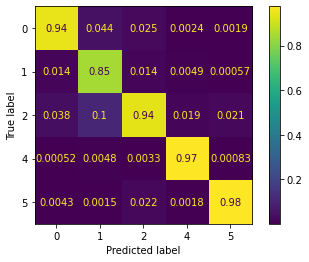

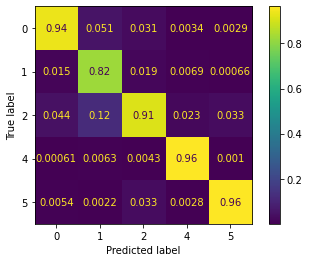

In [12]:
y_pred_train = model.predict(X_train)
print("Train accuracy: {}".format(accuracy_score(np.argmax(y_train, axis=1),
                                                 np.argmax(y_pred_train, axis=1))))
y_pred_test = model.predict(X_test)
print("Test accuracy: {}".format(accuracy_score(np.argmax(y_test, axis=1),
                                                np.argmax(y_pred_test, axis=1))))
plot_cm_keras(model, X_train, y_train)
plot_cm_keras(model, X_test, y_test)

In [ ]:
model.save('./models/model_{}_{}_{}'.format(minutes, sample_size, limb))